In [1]:
import pandas as pd
import numpy as np
import rdkit
import rdkit.Chem.AllChem
from tqdm import tqdm
from copy import deepcopy
import random
import os
import pickle
import matplotlib.pyplot as plt

In [2]:
from IPython.core.display import Image, display
def show_atom_number_2D(mol, label = 'atomNote'):
    mol_2D = deepcopy(mol)
    rdkit.Chem.rdDepictor.Compute2DCoords(mol_2D)
    for atom in mol_2D.GetAtoms():
        atom.SetProp(label, str(atom.GetIdx()))
    return mol_2D

def display_mol_with_index(mol):
    return display(rdkit.Chem.Draw.MolToImage(show_atom_number_2D(mol), size=(400, 400)))

def display_mol(mol):
    mol_2D = deepcopy(mol)
    rdkit.Chem.rdDepictor.Compute2DCoords(mol_2D)
    return display(rdkit.Chem.Draw.MolToImage(mol_2D, size=(400, 400)))

/state/partition1/slurm_tmp/27552405.0.0/ipykernel_1257267/3981475789.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import Image, display


In [3]:
def get_COOH_idx(mol):
    
    substructure = rdkit.Chem.MolFromSmarts('[CX3](=O)[OX2H1]')
    indexsall = mol.GetSubstructMatches(substructure)
    o_append=[]
    for i, num in enumerate(range(mol.GetNumAtoms())):
        if i in indexsall[0]:
            if mol.GetAtomWithIdx(i).GetSymbol() == 'C':
                C1 = i
            if mol.GetAtomWithIdx(i).GetSymbol() == 'O':
                o_append.append(i)
    for o in o_append:
        if mol.GetBondBetweenAtoms(o,C1).GetBondType() == rdkit.Chem.rdchem.BondType.SINGLE:
            O3 = o
        if mol.GetBondBetweenAtoms(o,C1).GetBondType() == rdkit.Chem.rdchem.BondType.DOUBLE:
            O2 = o
    for nei in mol.GetAtomWithIdx(C1).GetNeighbors():
        if nei.GetSymbol() =='C':
            C4 = nei.GetIdx()
    for nei in mol.GetAtomWithIdx(O3).GetNeighbors():
        if nei.GetSymbol() =='H':
            H5 = nei.GetIdx()
            
    return C1, O2, O3, C4, H5

from morfeus import BuriedVolume, Sterimol
def prop_calc_acid(m) :
    
    #get index of acid
    C1, O2, O3, C4, H5 = get_COOH_idx(m)
    
    #need xyz coords and elements
    coords = m.GetConformers()[0].GetPositions()
    elements = np.array([atom.GetSymbol() for atom in m.GetAtoms()])
    #Sterimol
    L_C1_C4 = Sterimol(elements, coords, C1+1, C4+1).L_value
    B5_C1_C4 = Sterimol(elements, coords, C1+1, C4+1).B_5_value
    #B1_C1_C4 = Sterimol(elements, coords, C1+1, C4+1).B_1_value
    
    return L_C1_C4, B5_C1_C4 

In [30]:
### PARAMETERS ###

prop = 'Sterimol_B5'
agg = 'max'


# collecting all inference metrics
results_dict_seeds = {}
for SEED in [0,1,2]:
    
    directory = f'jobs_acid_benchmark_seed{SEED}/'
    results_dict = {}

    parent_dir = directory + 'jobs/'
    dirs = next(os.walk(parent_dir))[1]
    dirs = [parent_dir + d for d in dirs]
    for d in tqdm(dirs):
        results = np.load(f'{d}/test_predictions.npy')
        targets = results[0]
        pred_targets = results[1]
        MAE = np.mean(np.abs(targets - pred_targets))
        R2 = np.corrcoef(targets, pred_targets)[0][1] ** 2
        results_dict[d] = (MAE, R2)

    
    target_df = pd.read_pickle(
        f'jobs_acid_benchmark_seed{SEED}/jobs_active/bond_{prop}_none_{agg}_DFT_1_2_DimeNetPlusPlus_0_none_1000_seed{SEED}/test_df.pkl'
    )
    test_names = sorted(list(set(target_df.Name_int)))
    
    rdkit_conformer_ensemble = pd.read_pickle('acid_data/rdkit_ensembles_name.pickle')
    rdkit_conformer_ensemble = {k[0]:rdkit_conformer_ensemble[k] for k in rdkit_conformer_ensemble}
    rdkit_ensemble_df = pd.DataFrame()
    rdkit_ensemble_df['Name_int'] = test_names
    max_L = []
    min_L = []
    max_B5 = []
    min_B5 = []
    for name in tqdm(test_names):
        confs = rdkit_conformer_ensemble[name]
        values = [prop_calc_acid(m) for m in confs]
        values_L = [v[0] for v in values]
        values_B5 = [v[1] for v in values]
        
        max_L.append(max(values_L))
        min_L.append(min(values_L))
        max_B5.append(max(values_B5))
        min_B5.append(min(values_B5))
    
    rdkit_ensemble_df['max_Sterimol_L'] = max_L
    rdkit_ensemble_df['min_Sterimol_L'] = min_L
    rdkit_ensemble_df['max_Sterimol_B5'] = max_B5
    rdkit_ensemble_df['min_Sterimol_B5'] = min_B5
    
    
    xtb_conformer_ensemble = pd.read_pickle('acid_data/rdkit_to_xtb_ensembles_name.pickle')
    xtb_conformer_ensemble = {k[0]:xtb_conformer_ensemble[k] for k in xtb_conformer_ensemble}
    xtb_ensemble_df = pd.DataFrame()
    xtb_ensemble_df['Name_int'] = test_names
    max_L = []
    min_L = []
    max_B5 = []
    min_B5 = []
    for name in tqdm(test_names):
        confs = xtb_conformer_ensemble[name]
        values = [prop_calc_acid(m) for m in confs]
        values_L = [v[0] for v in values]
        values_B5 = [v[1] for v in values]
        
        max_L.append(max(values_L))
        min_L.append(min(values_L))
        max_B5.append(max(values_B5))
        min_B5.append(min(values_B5))
    
    xtb_ensemble_df['max_Sterimol_L'] = max_L
    xtb_ensemble_df['min_Sterimol_L'] = min_L
    xtb_ensemble_df['max_Sterimol_B5'] = max_B5
    xtb_ensemble_df['min_Sterimol_B5'] = min_B5
    
    
    computed_rdkit_ensemble_MAE = np.mean(np.abs(np.array(rdkit_ensemble_df[f'{agg}_{prop}']) - np.array(list(target_df.y))))
    computed_rdkit_ensemble_R2 = np.corrcoef(
        np.array(rdkit_ensemble_df[f'{agg}_{prop}']),
        np.array(list(target_df.y))
    )[1,0] ** 2.0
    
    
    computed_xtb_ensemble_MAE = np.mean(np.abs(np.array(xtb_ensemble_df[f'{agg}_{prop}']) - np.array(list(target_df.y))))
    computed_xtb_ensemble_R2 = np.corrcoef(
        np.array(xtb_ensemble_df[f'{agg}_{prop}']),
        np.array(list(target_df.y))
    )[1,0] ** 2.0
    
    print(computed_rdkit_ensemble_MAE, computed_xtb_ensemble_MAE)
    
    
    results_dict['computed_rdkit_ensemble_MAE']=computed_rdkit_ensemble_MAE
    results_dict['computed_xtb_ensemble_MAE']=computed_xtb_ensemble_MAE
    
    results_dict['computed_rdkit_ensemble_R2']=computed_rdkit_ensemble_R2
    results_dict['computed_xtb_ensemble_R2']=computed_xtb_ensemble_R2
    
    results_dict_seeds[SEED] = results_dict
    

computed_rdkit_ensemble_MAE_seeds = [results_dict_seeds[i]['computed_rdkit_ensemble_MAE'] for i in [0,1,2]]
computed_xtb_ensemble_MAE_seeds = [results_dict_seeds[i]['computed_xtb_ensemble_MAE'] for i in [0,1,2]]



mae_3D_GNN_rdkit_seeds = []
r2_3D_GNN_rdkit_seeds = []

mae_3D_GNN_xtb_seeds = []
r2_3D_GNN_xtb_seeds = []

for SEED in [0,1,2]:
    results_dict = results_dict_seeds[SEED]
    directory = f'jobs_acid_benchmark_seed{SEED}/'
    
    dirs_3D_GNN_rdkit = [
        directory + f'jobs/bond_{prop}_{agg}_random_rdkit_1_2_DimeNetPlusPlus_0_none_1000_seed{SEED}',
        directory + f'jobs/bond_{prop}_{agg}_random_rdkit_1_2_DimeNetPlusPlus_0_none_500_seed{SEED}',
        directory + f'jobs/bond_{prop}_{agg}_random_rdkit_1_2_DimeNetPlusPlus_0_none_250_seed{SEED}',
        directory + f'jobs/bond_{prop}_{agg}_random_rdkit_1_2_DimeNetPlusPlus_0_none_125_seed{SEED}',
    ]
    mae_3D_GNN_rdkit = [results_dict[k][0].round(3) for k in dirs_3D_GNN_rdkit]
    r2_3D_GNN_rdkit = [results_dict[k][1].round(3) for k in dirs_3D_GNN_rdkit]
    mae_3D_GNN_rdkit_seeds.append(mae_3D_GNN_rdkit)
    r2_3D_GNN_rdkit_seeds.append(r2_3D_GNN_rdkit)
    
    
    
    dirs_3D_GNN_xtb = [
        directory + f'jobs/bond_{prop}_{agg}_random_xtb_1_2_DimeNetPlusPlus_0_none_1000_seed{SEED}',
        directory + f'jobs/bond_{prop}_{agg}_random_xtb_1_2_DimeNetPlusPlus_0_none_500_seed{SEED}',
        directory + f'jobs/bond_{prop}_{agg}_random_xtb_1_2_DimeNetPlusPlus_0_none_250_seed{SEED}',
        directory + f'jobs/bond_{prop}_{agg}_random_xtb_1_2_DimeNetPlusPlus_0_none_125_seed{SEED}',
    ]
    mae_3D_GNN_xtb = [results_dict[k][0].round(3) for k in dirs_3D_GNN_xtb]
    r2_3D_GNN_xtb = [results_dict[k][1].round(3) for k in dirs_3D_GNN_xtb]
    mae_3D_GNN_xtb_seeds.append(mae_3D_GNN_xtb)
    r2_3D_GNN_xtb_seeds.append(r2_3D_GNN_xtb)

100%|██████████| 1000/1000 [00:25<00:00, 38.53it/s]


0.201156390345197 0.19475907939524137


100%|██████████| 1000/1000 [00:25<00:00, 39.41it/s]


0.18812532267460605 0.1831355987542639


100%|██████████| 1000/1000 [00:19<00:00, 51.99it/s]

0.19654522130282237 0.1985860194080992


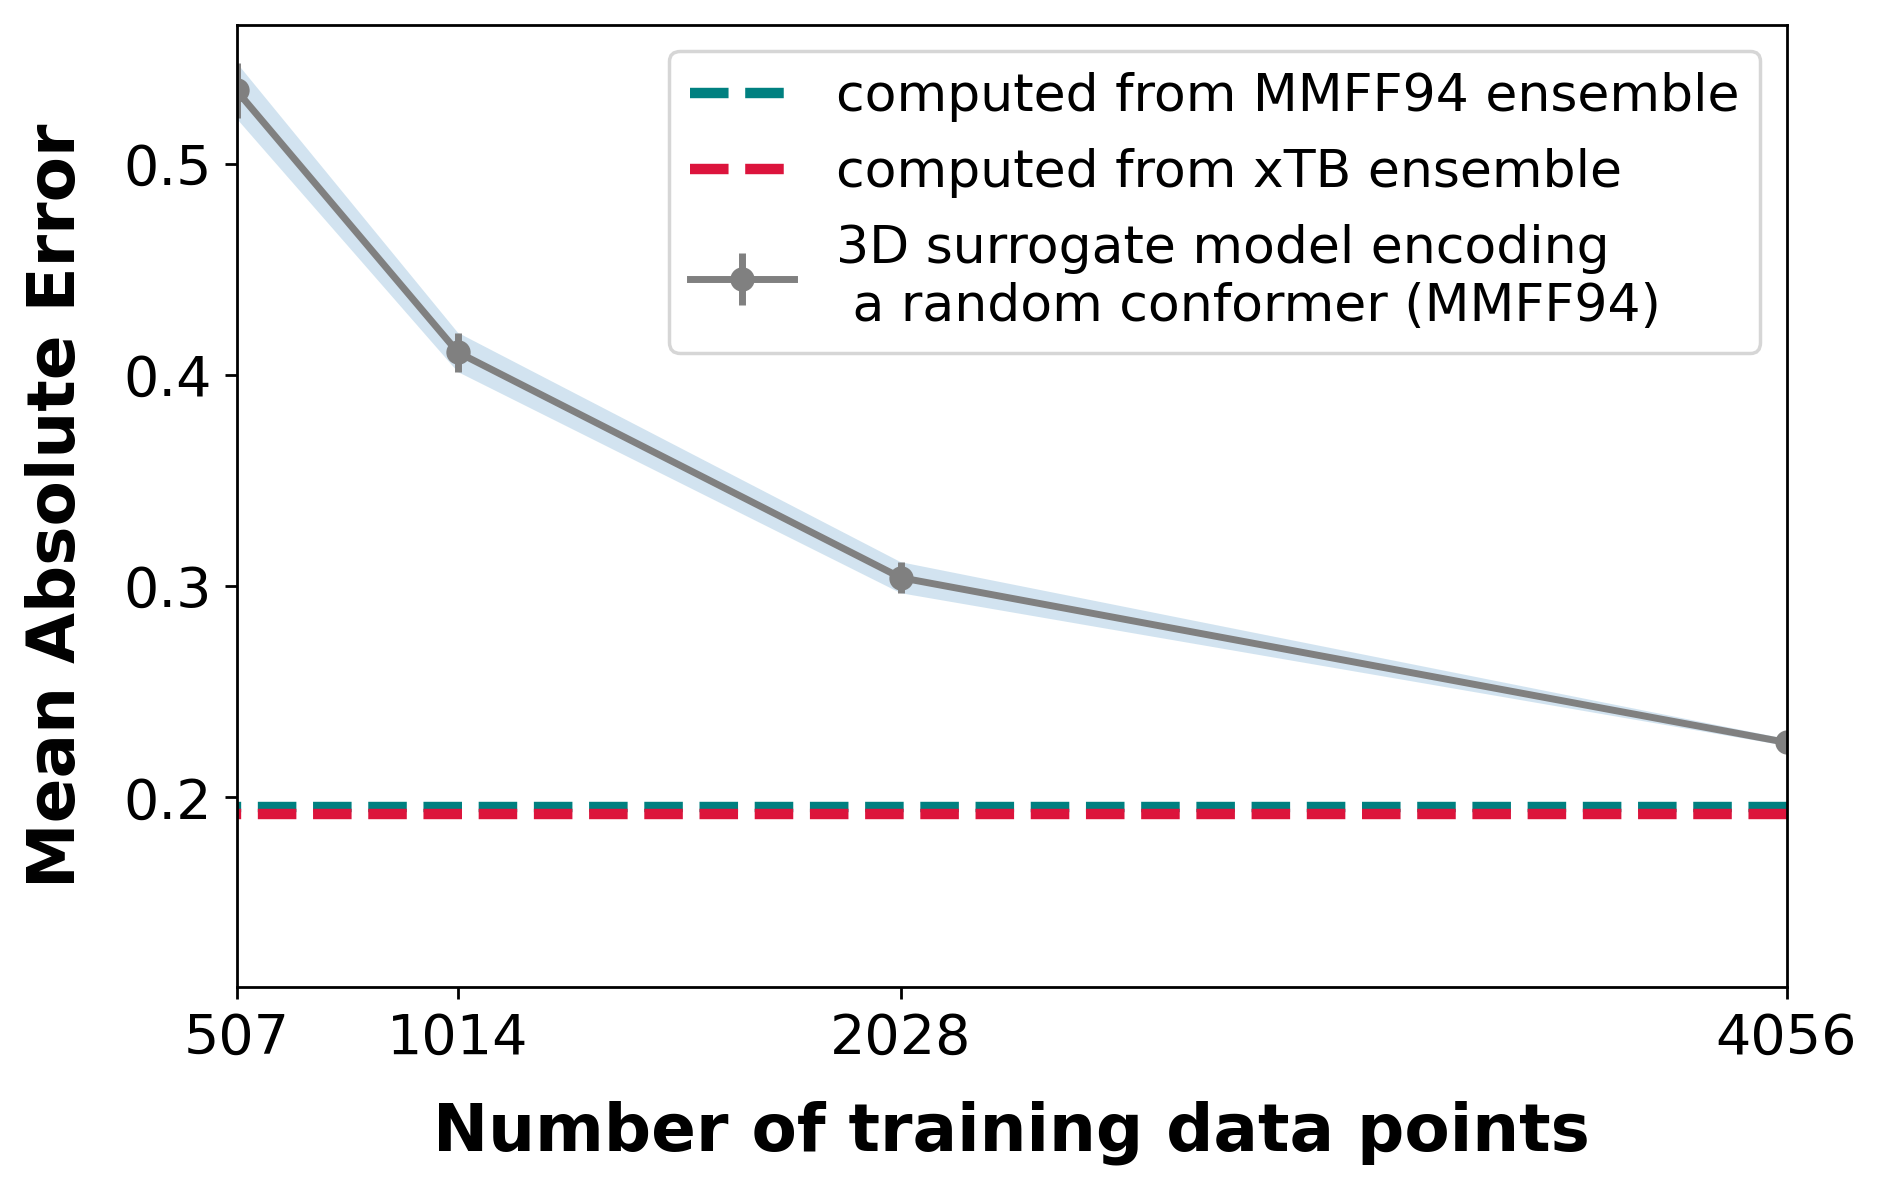

In [31]:
#plt.figure(figsize = (8,6), dpi = 250)
plt.figure(figsize = (8,5), dpi = 250)
x = [1.0, 0.5, 0.25, 0.125]

plt.hlines(y = [np.mean(np.array(computed_rdkit_ensemble_MAE_seeds))], xmin = x[0], xmax = x[-1], color = 'teal', linestyle = '--', label = 'computed from MMFF94 ensemble', linewidth = 3.0)
plt.hlines(y = [np.mean(np.array(computed_xtb_ensemble_MAE_seeds))], xmin = x[0], xmax = x[-1], color = 'crimson', linestyle = '--', label = 'computed from xTB ensemble', linewidth = 3.0)

y = np.mean(np.array(mae_3D_GNN_rdkit_seeds), axis = 0)
yerr=np.std(np.array(mae_3D_GNN_rdkit_seeds), axis = 0)
plt.errorbar(x, y, yerr=yerr, linewidth = 2.0, linestyle = '-', marker = 'o', label = '3D surrogate model encoding\n a random conformer (MMFF94)', color = 'grey');
plt.fill_between(x, y - yerr, y + yerr, alpha=0.2)

#y = np.mean(np.array(mae_3D_GNN_xtb_seeds), axis = 0)
#yerr=np.std(np.array(mae_3D_GNN_xtb_seeds), axis = 0)
#plt.errorbar(x, y, yerr=yerr, linewidth = 2.0, linestyle = '-', marker = 'o', label = 'xTB  surrogate model ', color = 'crimson');
#plt.fill_between(x, y - yerr, y + yerr, alpha=0.2)

plt.ylabel('Mean Absolute Error', fontsize = 19, labelpad = 10, fontweight = 'bold')
plt.xlim(0.125, 1.0)
#plt.xlabel('Fraction of data used to train surrogate models', fontsize = 19, labelpad = 10, fontweight = 'bold')
#plt.xticks(x, ['12.5%', '25%', '50%', '100%'][::-1], fontsize = 16)
plt.xlabel('Number of training data points', fontsize = 19, labelpad = 10, fontweight = 'bold')
plt.xticks(x, ['507', '1014', '2028', '4056'][::-1], fontsize = 16)
plt.yticks(fontsize = 16)
#plt.ylim(0.01, None)
plt.ylim(0.11, None)
plt.xticks(x)
plt.legend(fontsize = 15)
plt.show()

In [28]:
### PARAMETERS ###

prop = 'Sterimol_B5'
agg = 'min'


# collecting all inference metrics
results_dict_seeds = {}
for SEED in [0,1,2]:
    
    directory = f'jobs_acid_benchmark_seed{SEED}/'
    results_dict = {}

    parent_dir = directory + 'jobs/'
    dirs = next(os.walk(parent_dir))[1]
    dirs = [parent_dir + d for d in dirs]
    for d in tqdm(dirs):
        results = np.load(f'{d}/test_predictions.npy')
        targets = results[0]
        pred_targets = results[1]
        MAE = np.mean(np.abs(targets - pred_targets))
        R2 = np.corrcoef(targets, pred_targets)[0][1] ** 2
        results_dict[d] = (MAE, R2)

    
    target_df = pd.read_pickle(
        f'jobs_acid_benchmark_seed{SEED}/jobs_active/bond_{prop}_none_{agg}_DFT_1_2_DimeNetPlusPlus_0_none_1000_seed{SEED}/test_df.pkl'
    )
    test_names = sorted(list(set(target_df.Name_int)))
    
    rdkit_conformer_ensemble = pd.read_pickle('acid_data/rdkit_ensembles_name.pickle')
    rdkit_conformer_ensemble = {k[0]:rdkit_conformer_ensemble[k] for k in rdkit_conformer_ensemble}
    rdkit_ensemble_df = pd.DataFrame()
    rdkit_ensemble_df['Name_int'] = test_names
    max_L = []
    min_L = []
    max_B5 = []
    min_B5 = []
    for name in tqdm(test_names):
        confs = rdkit_conformer_ensemble[name]
        values = [prop_calc_acid(m) for m in confs]
        values_L = [v[0] for v in values]
        values_B5 = [v[1] for v in values]
        
        max_L.append(max(values_L))
        min_L.append(min(values_L))
        max_B5.append(max(values_B5))
        min_B5.append(min(values_B5))
    
    rdkit_ensemble_df['max_Sterimol_L'] = max_L
    rdkit_ensemble_df['min_Sterimol_L'] = min_L
    rdkit_ensemble_df['max_Sterimol_B5'] = max_B5
    rdkit_ensemble_df['min_Sterimol_B5'] = min_B5
    
    
    xtb_conformer_ensemble = pd.read_pickle('acid_data/rdkit_to_xtb_ensembles_name.pickle')
    xtb_conformer_ensemble = {k[0]:xtb_conformer_ensemble[k] for k in xtb_conformer_ensemble}
    xtb_ensemble_df = pd.DataFrame()
    xtb_ensemble_df['Name_int'] = test_names
    max_L = []
    min_L = []
    max_B5 = []
    min_B5 = []
    for name in tqdm(test_names):
        confs = xtb_conformer_ensemble[name]
        values = [prop_calc_acid(m) for m in confs]
        values_L = [v[0] for v in values]
        values_B5 = [v[1] for v in values]
        
        max_L.append(max(values_L))
        min_L.append(min(values_L))
        max_B5.append(max(values_B5))
        min_B5.append(min(values_B5))
    
    xtb_ensemble_df['max_Sterimol_L'] = max_L
    xtb_ensemble_df['min_Sterimol_L'] = min_L
    xtb_ensemble_df['max_Sterimol_B5'] = max_B5
    xtb_ensemble_df['min_Sterimol_B5'] = min_B5
    
    
    computed_rdkit_ensemble_MAE = np.mean(np.abs(np.array(rdkit_ensemble_df[f'{agg}_{prop}']) - np.array(list(target_df.y))))
    computed_rdkit_ensemble_R2 = np.corrcoef(
        np.array(rdkit_ensemble_df[f'{agg}_{prop}']),
        np.array(list(target_df.y))
    )[1,0] ** 2.0
    
    
    computed_xtb_ensemble_MAE = np.mean(np.abs(np.array(xtb_ensemble_df[f'{agg}_{prop}']) - np.array(list(target_df.y))))
    computed_xtb_ensemble_R2 = np.corrcoef(
        np.array(xtb_ensemble_df[f'{agg}_{prop}']),
        np.array(list(target_df.y))
    )[1,0] ** 2.0
    
    print(computed_rdkit_ensemble_MAE, computed_xtb_ensemble_MAE)
    
    
    results_dict['computed_rdkit_ensemble_MAE']=computed_rdkit_ensemble_MAE
    results_dict['computed_xtb_ensemble_MAE']=computed_xtb_ensemble_MAE
    
    results_dict['computed_rdkit_ensemble_R2']=computed_rdkit_ensemble_R2
    results_dict['computed_xtb_ensemble_R2']=computed_xtb_ensemble_R2
    
    results_dict_seeds[SEED] = results_dict
    

computed_rdkit_ensemble_MAE_seeds = [results_dict_seeds[i]['computed_rdkit_ensemble_MAE'] for i in [0,1,2]]
computed_xtb_ensemble_MAE_seeds = [results_dict_seeds[i]['computed_xtb_ensemble_MAE'] for i in [0,1,2]]



mae_3D_GNN_rdkit_seeds = []
r2_3D_GNN_rdkit_seeds = []

mae_3D_GNN_xtb_seeds = []
r2_3D_GNN_xtb_seeds = []

for SEED in [0,1,2]:
    results_dict = results_dict_seeds[SEED]
    directory = f'jobs_acid_benchmark_seed{SEED}/'
    
    dirs_3D_GNN_rdkit = [
        directory + f'jobs/bond_{prop}_{agg}_random_rdkit_1_2_DimeNetPlusPlus_0_none_1000_seed{SEED}',
        directory + f'jobs/bond_{prop}_{agg}_random_rdkit_1_2_DimeNetPlusPlus_0_none_500_seed{SEED}',
        directory + f'jobs/bond_{prop}_{agg}_random_rdkit_1_2_DimeNetPlusPlus_0_none_250_seed{SEED}',
        directory + f'jobs/bond_{prop}_{agg}_random_rdkit_1_2_DimeNetPlusPlus_0_none_125_seed{SEED}',
    ]
    mae_3D_GNN_rdkit = [results_dict[k][0].round(3) for k in dirs_3D_GNN_rdkit]
    r2_3D_GNN_rdkit = [results_dict[k][1].round(3) for k in dirs_3D_GNN_rdkit]
    mae_3D_GNN_rdkit_seeds.append(mae_3D_GNN_rdkit)
    r2_3D_GNN_rdkit_seeds.append(r2_3D_GNN_rdkit)
    
    
    
    dirs_3D_GNN_xtb = [
        directory + f'jobs/bond_{prop}_{agg}_random_xtb_1_2_DimeNetPlusPlus_0_none_1000_seed{SEED}',
        directory + f'jobs/bond_{prop}_{agg}_random_xtb_1_2_DimeNetPlusPlus_0_none_500_seed{SEED}',
        directory + f'jobs/bond_{prop}_{agg}_random_xtb_1_2_DimeNetPlusPlus_0_none_250_seed{SEED}',
        directory + f'jobs/bond_{prop}_{agg}_random_xtb_1_2_DimeNetPlusPlus_0_none_125_seed{SEED}',
    ]
    mae_3D_GNN_xtb = [results_dict[k][0].round(3) for k in dirs_3D_GNN_xtb]
    r2_3D_GNN_xtb = [results_dict[k][1].round(3) for k in dirs_3D_GNN_xtb]
    mae_3D_GNN_xtb_seeds.append(mae_3D_GNN_xtb)
    r2_3D_GNN_xtb_seeds.append(r2_3D_GNN_xtb)

100%|██████████| 1000/1000 [00:25<00:00, 38.74it/s]


0.3111908675064146 0.2623773127335221


100%|██████████| 1000/1000 [00:26<00:00, 37.71it/s]


0.2804209773842813 0.2572676916402431


100%|██████████| 1000/1000 [00:28<00:00, 35.12it/s]

0.3024142912300637 0.2611007947168233


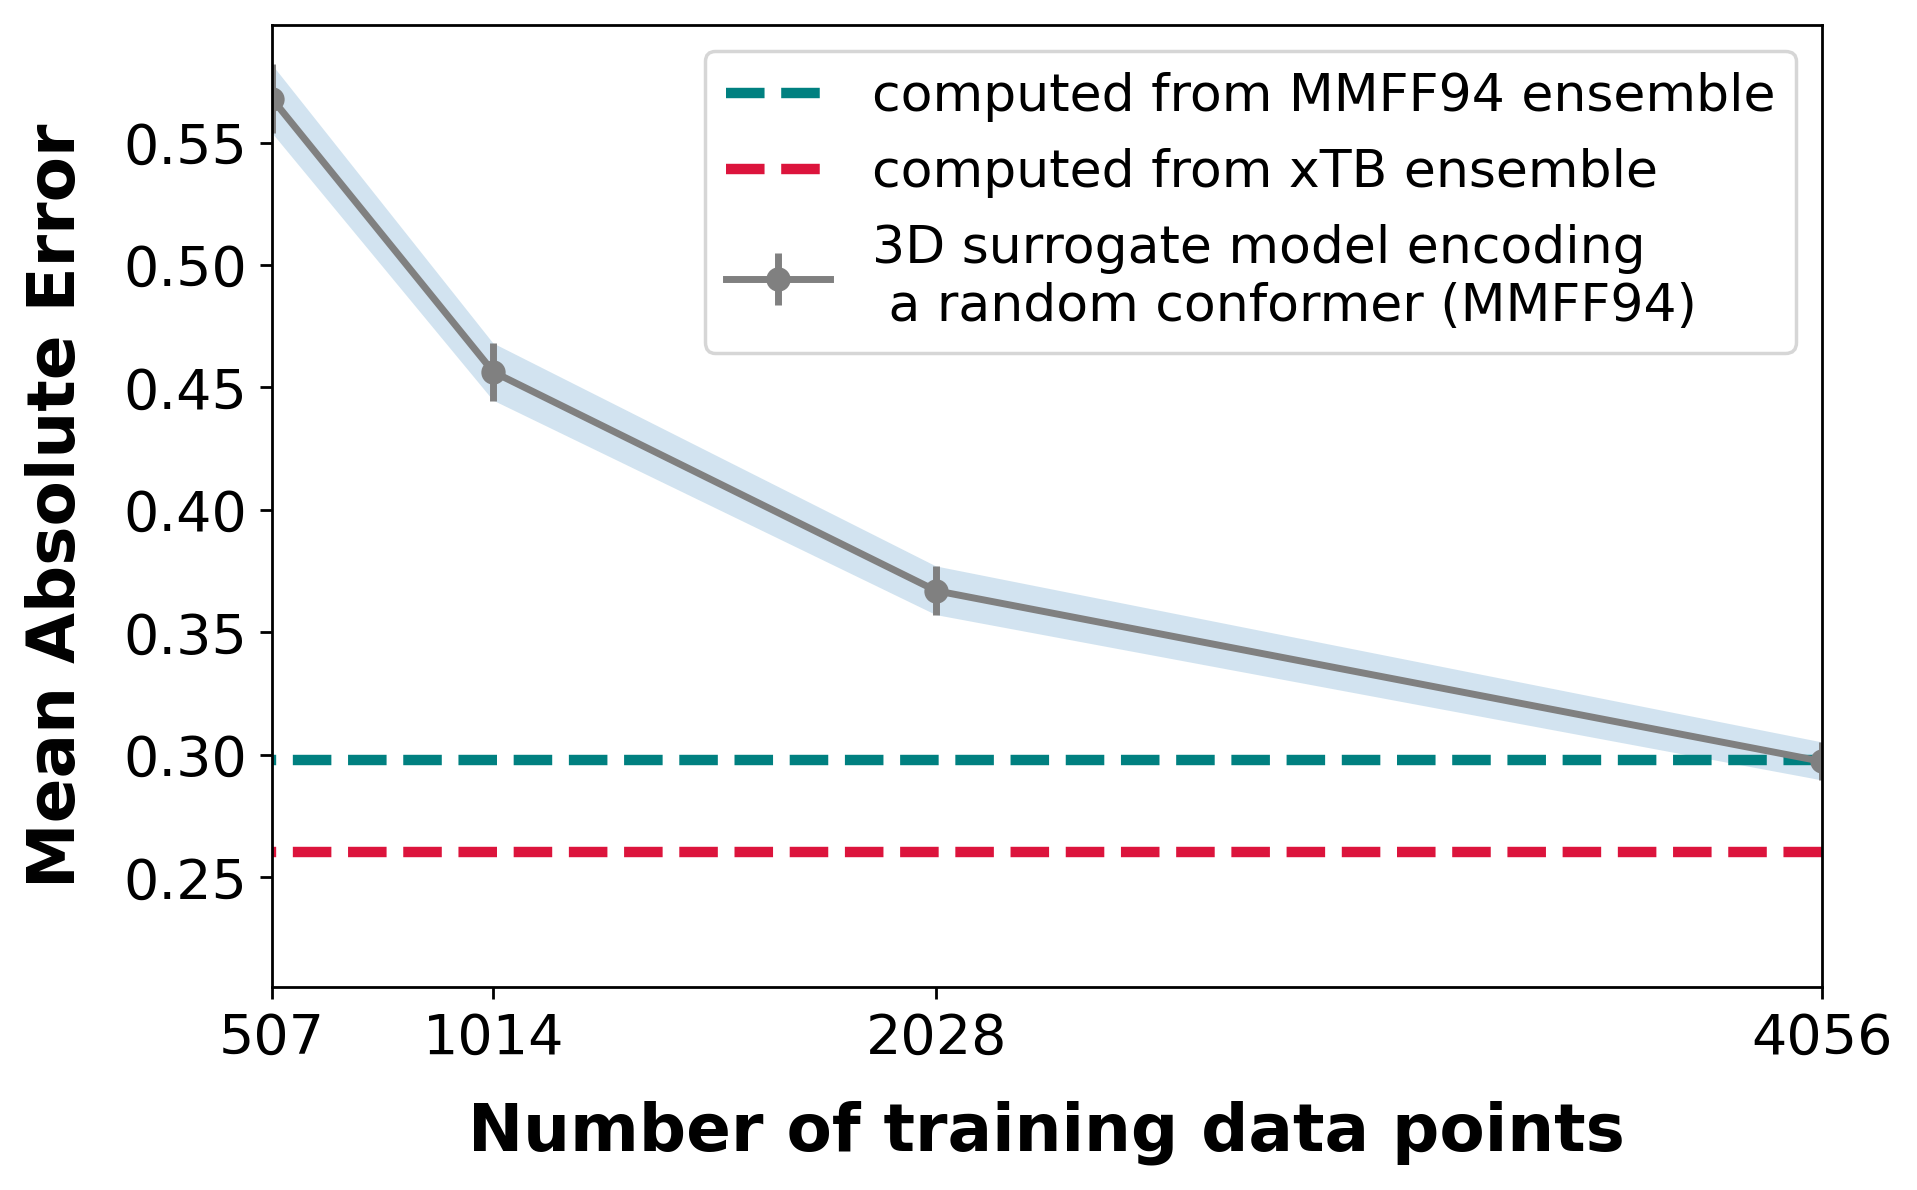

In [29]:
#plt.figure(figsize = (8,6), dpi = 250)
plt.figure(figsize = (8,5), dpi = 250)
x = [1.0, 0.5, 0.25, 0.125]

plt.hlines(y = [np.mean(np.array(computed_rdkit_ensemble_MAE_seeds))], xmin = x[0], xmax = x[-1], color = 'teal', linestyle = '--', label = 'computed from MMFF94 ensemble', linewidth = 3.0)
plt.hlines(y = [np.mean(np.array(computed_xtb_ensemble_MAE_seeds))], xmin = x[0], xmax = x[-1], color = 'crimson', linestyle = '--', label = 'computed from xTB ensemble', linewidth = 3.0)

y = np.mean(np.array(mae_3D_GNN_rdkit_seeds), axis = 0)
yerr=np.std(np.array(mae_3D_GNN_rdkit_seeds), axis = 0)
plt.errorbar(x, y, yerr=yerr, linewidth = 2.0, linestyle = '-', marker = 'o', label = '3D surrogate model encoding\n a random conformer (MMFF94)', color = 'grey');
plt.fill_between(x, y - yerr, y + yerr, alpha=0.2)

#y = np.mean(np.array(mae_3D_GNN_xtb_seeds), axis = 0)
#yerr=np.std(np.array(mae_3D_GNN_xtb_seeds), axis = 0)
#plt.errorbar(x, y, yerr=yerr, linewidth = 2.0, linestyle = '-', marker = 'o', label = 'xTB  surrogate model ', color = 'crimson');
#plt.fill_between(x, y - yerr, y + yerr, alpha=0.2)

plt.ylabel('Mean Absolute Error', fontsize = 19, labelpad = 10, fontweight = 'bold')
plt.xlim(0.125, 1.0)
#plt.xlabel('Fraction of data used to train surrogate models', fontsize = 19, labelpad = 10, fontweight = 'bold')
#plt.xticks(x, ['12.5%', '25%', '50%', '100%'][::-1], fontsize = 16)
plt.xlabel('Number of training data points', fontsize = 19, labelpad = 10, fontweight = 'bold')
plt.xticks(x, ['507', '1014', '2028', '4056'][::-1], fontsize = 16)
plt.yticks(fontsize = 16)
#plt.ylim(0.01, None)
plt.ylim(0.205, None)
plt.xticks(x)
plt.legend(fontsize = 15)
plt.show()

In [26]:
### PARAMETERS ###

prop = 'Sterimol_L'
agg = 'max'


# collecting all inference metrics
results_dict_seeds = {}
for SEED in [0,1,2]:
    
    directory = f'jobs_acid_benchmark_seed{SEED}/'
    results_dict = {}

    parent_dir = directory + 'jobs/'
    dirs = next(os.walk(parent_dir))[1]
    dirs = [parent_dir + d for d in dirs]
    for d in tqdm(dirs):
        results = np.load(f'{d}/test_predictions.npy')
        targets = results[0]
        pred_targets = results[1]
        MAE = np.mean(np.abs(targets - pred_targets))
        R2 = np.corrcoef(targets, pred_targets)[0][1] ** 2
        results_dict[d] = (MAE, R2)

    
    target_df = pd.read_pickle(
        f'jobs_acid_benchmark_seed{SEED}/jobs_active/bond_{prop}_none_{agg}_DFT_1_2_DimeNetPlusPlus_0_none_1000_seed{SEED}/test_df.pkl'
    )
    test_names = sorted(list(set(target_df.Name_int)))
    
    rdkit_conformer_ensemble = pd.read_pickle('acid_data/rdkit_ensembles_name.pickle')
    rdkit_conformer_ensemble = {k[0]:rdkit_conformer_ensemble[k] for k in rdkit_conformer_ensemble}
    rdkit_ensemble_df = pd.DataFrame()
    rdkit_ensemble_df['Name_int'] = test_names
    max_L = []
    min_L = []
    max_B5 = []
    min_B5 = []
    for name in tqdm(test_names):
        confs = rdkit_conformer_ensemble[name]
        values = [prop_calc_acid(m) for m in confs]
        values_L = [v[0] for v in values]
        values_B5 = [v[1] for v in values]
        
        max_L.append(max(values_L))
        min_L.append(min(values_L))
        max_B5.append(max(values_B5))
        min_B5.append(min(values_B5))
    
    rdkit_ensemble_df['max_Sterimol_L'] = max_L
    rdkit_ensemble_df['min_Sterimol_L'] = min_L
    rdkit_ensemble_df['max_Sterimol_B5'] = max_B5
    rdkit_ensemble_df['min_Sterimol_B5'] = min_B5
    
    
    xtb_conformer_ensemble = pd.read_pickle('acid_data/rdkit_to_xtb_ensembles_name.pickle')
    xtb_conformer_ensemble = {k[0]:xtb_conformer_ensemble[k] for k in xtb_conformer_ensemble}
    xtb_ensemble_df = pd.DataFrame()
    xtb_ensemble_df['Name_int'] = test_names
    max_L = []
    min_L = []
    max_B5 = []
    min_B5 = []
    for name in tqdm(test_names):
        confs = xtb_conformer_ensemble[name]
        values = [prop_calc_acid(m) for m in confs]
        values_L = [v[0] for v in values]
        values_B5 = [v[1] for v in values]
        
        max_L.append(max(values_L))
        min_L.append(min(values_L))
        max_B5.append(max(values_B5))
        min_B5.append(min(values_B5))
    
    xtb_ensemble_df['max_Sterimol_L'] = max_L
    xtb_ensemble_df['min_Sterimol_L'] = min_L
    xtb_ensemble_df['max_Sterimol_B5'] = max_B5
    xtb_ensemble_df['min_Sterimol_B5'] = min_B5
    
    
    computed_rdkit_ensemble_MAE = np.mean(np.abs(np.array(rdkit_ensemble_df[f'{agg}_{prop}']) - np.array(list(target_df.y))))
    computed_rdkit_ensemble_R2 = np.corrcoef(
        np.array(rdkit_ensemble_df[f'{agg}_{prop}']),
        np.array(list(target_df.y))
    )[1,0] ** 2.0
    
    
    computed_xtb_ensemble_MAE = np.mean(np.abs(np.array(xtb_ensemble_df[f'{agg}_{prop}']) - np.array(list(target_df.y))))
    computed_xtb_ensemble_R2 = np.corrcoef(
        np.array(xtb_ensemble_df[f'{agg}_{prop}']),
        np.array(list(target_df.y))
    )[1,0] ** 2.0
    
    print(computed_rdkit_ensemble_MAE, computed_xtb_ensemble_MAE)
    
    
    results_dict['computed_rdkit_ensemble_MAE']=computed_rdkit_ensemble_MAE
    results_dict['computed_xtb_ensemble_MAE']=computed_xtb_ensemble_MAE
    
    results_dict['computed_rdkit_ensemble_R2']=computed_rdkit_ensemble_R2
    results_dict['computed_xtb_ensemble_R2']=computed_xtb_ensemble_R2
    
    results_dict_seeds[SEED] = results_dict
    

computed_rdkit_ensemble_MAE_seeds = [results_dict_seeds[i]['computed_rdkit_ensemble_MAE'] for i in [0,1,2]]
computed_xtb_ensemble_MAE_seeds = [results_dict_seeds[i]['computed_xtb_ensemble_MAE'] for i in [0,1,2]]



mae_3D_GNN_rdkit_seeds = []
r2_3D_GNN_rdkit_seeds = []

mae_3D_GNN_xtb_seeds = []
r2_3D_GNN_xtb_seeds = []

for SEED in [0,1,2]:
    results_dict = results_dict_seeds[SEED]
    directory = f'jobs_acid_benchmark_seed{SEED}/'
    
    dirs_3D_GNN_rdkit = [
        directory + f'jobs/bond_{prop}_{agg}_random_rdkit_1_2_DimeNetPlusPlus_0_none_1000_seed{SEED}',
        directory + f'jobs/bond_{prop}_{agg}_random_rdkit_1_2_DimeNetPlusPlus_0_none_500_seed{SEED}',
        directory + f'jobs/bond_{prop}_{agg}_random_rdkit_1_2_DimeNetPlusPlus_0_none_250_seed{SEED}',
        directory + f'jobs/bond_{prop}_{agg}_random_rdkit_1_2_DimeNetPlusPlus_0_none_125_seed{SEED}',
    ]
    mae_3D_GNN_rdkit = [results_dict[k][0].round(3) for k in dirs_3D_GNN_rdkit]
    r2_3D_GNN_rdkit = [results_dict[k][1].round(3) for k in dirs_3D_GNN_rdkit]
    mae_3D_GNN_rdkit_seeds.append(mae_3D_GNN_rdkit)
    r2_3D_GNN_rdkit_seeds.append(r2_3D_GNN_rdkit)
    
    
    
    dirs_3D_GNN_xtb = [
        directory + f'jobs/bond_{prop}_{agg}_random_xtb_1_2_DimeNetPlusPlus_0_none_1000_seed{SEED}',
        directory + f'jobs/bond_{prop}_{agg}_random_xtb_1_2_DimeNetPlusPlus_0_none_500_seed{SEED}',
        directory + f'jobs/bond_{prop}_{agg}_random_xtb_1_2_DimeNetPlusPlus_0_none_250_seed{SEED}',
        directory + f'jobs/bond_{prop}_{agg}_random_xtb_1_2_DimeNetPlusPlus_0_none_125_seed{SEED}',
    ]
    mae_3D_GNN_xtb = [results_dict[k][0].round(3) for k in dirs_3D_GNN_xtb]
    r2_3D_GNN_xtb = [results_dict[k][1].round(3) for k in dirs_3D_GNN_xtb]
    mae_3D_GNN_xtb_seeds.append(mae_3D_GNN_xtb)
    r2_3D_GNN_xtb_seeds.append(r2_3D_GNN_xtb)

100%|██████████| 1000/1000 [00:19<00:00, 50.04it/s]


0.3223510762733067 0.3169628377461029


100%|██████████| 1000/1000 [00:23<00:00, 42.43it/s]


0.29913593720580717 0.3229525366683304


100%|██████████| 1000/1000 [00:22<00:00, 45.14it/s]

0.28976912594539245 0.3123255281793576


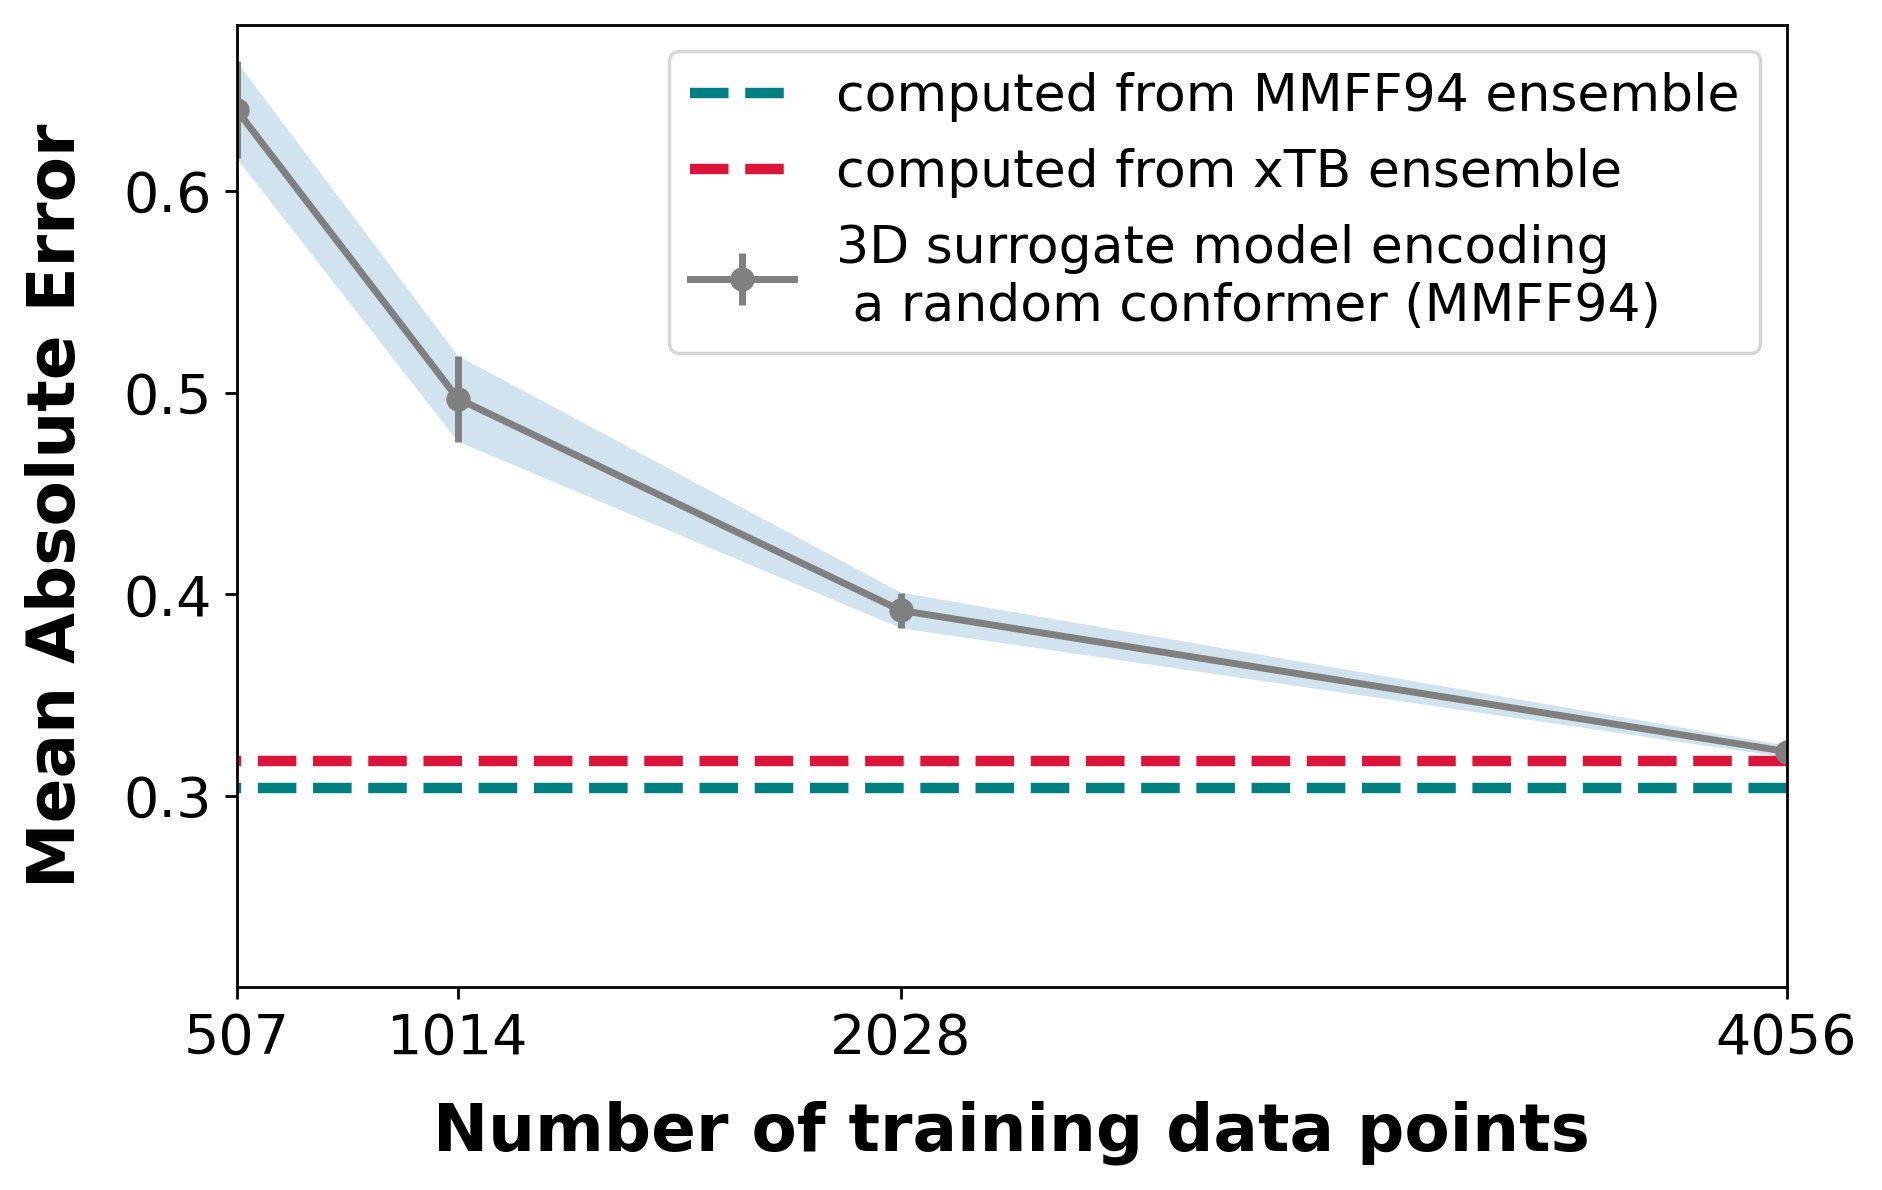

In [27]:
#plt.figure(figsize = (8,6), dpi = 250)
plt.figure(figsize = (8,5), dpi = 250)
x = [1.0, 0.5, 0.25, 0.125]

plt.hlines(y = [np.mean(np.array(computed_rdkit_ensemble_MAE_seeds))], xmin = x[0], xmax = x[-1], color = 'teal', linestyle = '--', label = 'computed from MMFF94 ensemble', linewidth = 3.0)
plt.hlines(y = [np.mean(np.array(computed_xtb_ensemble_MAE_seeds))], xmin = x[0], xmax = x[-1], color = 'crimson', linestyle = '--', label = 'computed from xTB ensemble', linewidth = 3.0)

y = np.mean(np.array(mae_3D_GNN_rdkit_seeds), axis = 0)
yerr=np.std(np.array(mae_3D_GNN_rdkit_seeds), axis = 0)
plt.errorbar(x, y, yerr=yerr, linewidth = 2.0, linestyle = '-', marker = 'o', label = '3D surrogate model encoding\n a random conformer (MMFF94)', color = 'grey');
plt.fill_between(x, y - yerr, y + yerr, alpha=0.2)

#y = np.mean(np.array(mae_3D_GNN_xtb_seeds), axis = 0)
#yerr=np.std(np.array(mae_3D_GNN_xtb_seeds), axis = 0)
#plt.errorbar(x, y, yerr=yerr, linewidth = 2.0, linestyle = '-', marker = 'o', label = 'xTB  surrogate model ', color = 'crimson');
#plt.fill_between(x, y - yerr, y + yerr, alpha=0.2)

plt.ylabel('Mean Absolute Error', fontsize = 19, labelpad = 10, fontweight = 'bold')
plt.xlim(0.125, 1.0)
#plt.xlabel('Fraction of data used to train surrogate models', fontsize = 19, labelpad = 10, fontweight = 'bold')
#plt.xticks(x, ['12.5%', '25%', '50%', '100%'][::-1], fontsize = 16)
plt.xlabel('Number of training data points', fontsize = 19, labelpad = 10, fontweight = 'bold')
plt.xticks(x, ['507', '1014', '2028', '4056'][::-1], fontsize = 16)
plt.yticks(fontsize = 16)
#plt.ylim(0.12, None)
plt.ylim(0.205, None)
plt.xticks(x)
plt.legend(fontsize = 15)
plt.show()

In [22]:
### PARAMETERS ###

prop = 'Sterimol_L'
agg = 'min'


# collecting all inference metrics
results_dict_seeds = {}
for SEED in [0,1,2]:
    
    directory = f'jobs_acid_benchmark_seed{SEED}/'
    results_dict = {}

    parent_dir = directory + 'jobs/'
    dirs = next(os.walk(parent_dir))[1]
    dirs = [parent_dir + d for d in dirs]
    for d in tqdm(dirs):
        results = np.load(f'{d}/test_predictions.npy')
        targets = results[0]
        pred_targets = results[1]
        MAE = np.mean(np.abs(targets - pred_targets))
        R2 = np.corrcoef(targets, pred_targets)[0][1] ** 2
        results_dict[d] = (MAE, R2)

    
    target_df = pd.read_pickle(
        f'jobs_acid_benchmark_seed{SEED}/jobs_active/bond_{prop}_none_{agg}_DFT_1_2_DimeNetPlusPlus_0_none_1000_seed{SEED}/test_df.pkl'
    )
    test_names = sorted(list(set(target_df.Name_int)))
    
    rdkit_conformer_ensemble = pd.read_pickle('acid_data/rdkit_ensembles_name.pickle')
    rdkit_conformer_ensemble = {k[0]:rdkit_conformer_ensemble[k] for k in rdkit_conformer_ensemble}
    rdkit_ensemble_df = pd.DataFrame()
    rdkit_ensemble_df['Name_int'] = test_names
    max_L = []
    min_L = []
    max_B5 = []
    min_B5 = []
    for name in tqdm(test_names):
        confs = rdkit_conformer_ensemble[name]
        values = [prop_calc_acid(m) for m in confs]
        values_L = [v[0] for v in values]
        values_B5 = [v[1] for v in values]
        
        max_L.append(max(values_L))
        min_L.append(min(values_L))
        max_B5.append(max(values_B5))
        min_B5.append(min(values_B5))
    
    rdkit_ensemble_df['max_Sterimol_L'] = max_L
    rdkit_ensemble_df['min_Sterimol_L'] = min_L
    rdkit_ensemble_df['max_Sterimol_B5'] = max_B5
    rdkit_ensemble_df['min_Sterimol_B5'] = min_B5
    
    
    xtb_conformer_ensemble = pd.read_pickle('acid_data/rdkit_to_xtb_ensembles_name.pickle')
    xtb_conformer_ensemble = {k[0]:xtb_conformer_ensemble[k] for k in xtb_conformer_ensemble}
    xtb_ensemble_df = pd.DataFrame()
    xtb_ensemble_df['Name_int'] = test_names
    max_L = []
    min_L = []
    max_B5 = []
    min_B5 = []
    for name in tqdm(test_names):
        confs = xtb_conformer_ensemble[name]
        values = [prop_calc_acid(m) for m in confs]
        values_L = [v[0] for v in values]
        values_B5 = [v[1] for v in values]
        
        max_L.append(max(values_L))
        min_L.append(min(values_L))
        max_B5.append(max(values_B5))
        min_B5.append(min(values_B5))
    
    xtb_ensemble_df['max_Sterimol_L'] = max_L
    xtb_ensemble_df['min_Sterimol_L'] = min_L
    xtb_ensemble_df['max_Sterimol_B5'] = max_B5
    xtb_ensemble_df['min_Sterimol_B5'] = min_B5
    
    
    computed_rdkit_ensemble_MAE = np.mean(np.abs(np.array(rdkit_ensemble_df[f'{agg}_{prop}']) - np.array(list(target_df.y))))
    computed_rdkit_ensemble_R2 = np.corrcoef(
        np.array(rdkit_ensemble_df[f'{agg}_{prop}']),
        np.array(list(target_df.y))
    )[1,0] ** 2.0
    
    
    computed_xtb_ensemble_MAE = np.mean(np.abs(np.array(xtb_ensemble_df[f'{agg}_{prop}']) - np.array(list(target_df.y))))
    computed_xtb_ensemble_R2 = np.corrcoef(
        np.array(xtb_ensemble_df[f'{agg}_{prop}']),
        np.array(list(target_df.y))
    )[1,0] ** 2.0
    
    print(computed_rdkit_ensemble_MAE, computed_xtb_ensemble_MAE)
    
    
    results_dict['computed_rdkit_ensemble_MAE']=computed_rdkit_ensemble_MAE
    results_dict['computed_xtb_ensemble_MAE']=computed_xtb_ensemble_MAE
    
    results_dict['computed_rdkit_ensemble_R2']=computed_rdkit_ensemble_R2
    results_dict['computed_xtb_ensemble_R2']=computed_xtb_ensemble_R2
    
    results_dict_seeds[SEED] = results_dict
    

computed_rdkit_ensemble_MAE_seeds = [results_dict_seeds[i]['computed_rdkit_ensemble_MAE'] for i in [0,1,2]]
computed_xtb_ensemble_MAE_seeds = [results_dict_seeds[i]['computed_xtb_ensemble_MAE'] for i in [0,1,2]]



mae_3D_GNN_rdkit_seeds = []
r2_3D_GNN_rdkit_seeds = []

mae_3D_GNN_xtb_seeds = []
r2_3D_GNN_xtb_seeds = []

for SEED in [0,1,2]:
    results_dict = results_dict_seeds[SEED]
    directory = f'jobs_acid_benchmark_seed{SEED}/'
    
    dirs_3D_GNN_rdkit = [
        directory + f'jobs/bond_{prop}_{agg}_random_rdkit_1_2_DimeNetPlusPlus_0_none_1000_seed{SEED}',
        directory + f'jobs/bond_{prop}_{agg}_random_rdkit_1_2_DimeNetPlusPlus_0_none_500_seed{SEED}',
        directory + f'jobs/bond_{prop}_{agg}_random_rdkit_1_2_DimeNetPlusPlus_0_none_250_seed{SEED}',
        directory + f'jobs/bond_{prop}_{agg}_random_rdkit_1_2_DimeNetPlusPlus_0_none_125_seed{SEED}',
    ]
    mae_3D_GNN_rdkit = [results_dict[k][0].round(3) for k in dirs_3D_GNN_rdkit]
    r2_3D_GNN_rdkit = [results_dict[k][1].round(3) for k in dirs_3D_GNN_rdkit]
    mae_3D_GNN_rdkit_seeds.append(mae_3D_GNN_rdkit)
    r2_3D_GNN_rdkit_seeds.append(r2_3D_GNN_rdkit)
    
    
    
    dirs_3D_GNN_xtb = [
        directory + f'jobs/bond_{prop}_{agg}_random_xtb_1_2_DimeNetPlusPlus_0_none_1000_seed{SEED}',
        directory + f'jobs/bond_{prop}_{agg}_random_xtb_1_2_DimeNetPlusPlus_0_none_500_seed{SEED}',
        directory + f'jobs/bond_{prop}_{agg}_random_xtb_1_2_DimeNetPlusPlus_0_none_250_seed{SEED}',
        directory + f'jobs/bond_{prop}_{agg}_random_xtb_1_2_DimeNetPlusPlus_0_none_125_seed{SEED}',
    ]
    mae_3D_GNN_xtb = [results_dict[k][0].round(3) for k in dirs_3D_GNN_xtb]
    r2_3D_GNN_xtb = [results_dict[k][1].round(3) for k in dirs_3D_GNN_xtb]
    mae_3D_GNN_xtb_seeds.append(mae_3D_GNN_xtb)
    r2_3D_GNN_xtb_seeds.append(r2_3D_GNN_xtb)

100%|██████████| 1000/1000 [00:15<00:00, 63.56it/s]


0.2751095385805548 0.20934018431234813


100%|██████████| 1000/1000 [00:23<00:00, 42.12it/s]


0.25397124286030953 0.2074658326406351


100%|██████████| 1000/1000 [00:22<00:00, 43.83it/s]

0.26464451741864636 0.21155678529082547


<Figure size 2000x1500 with 0 Axes>

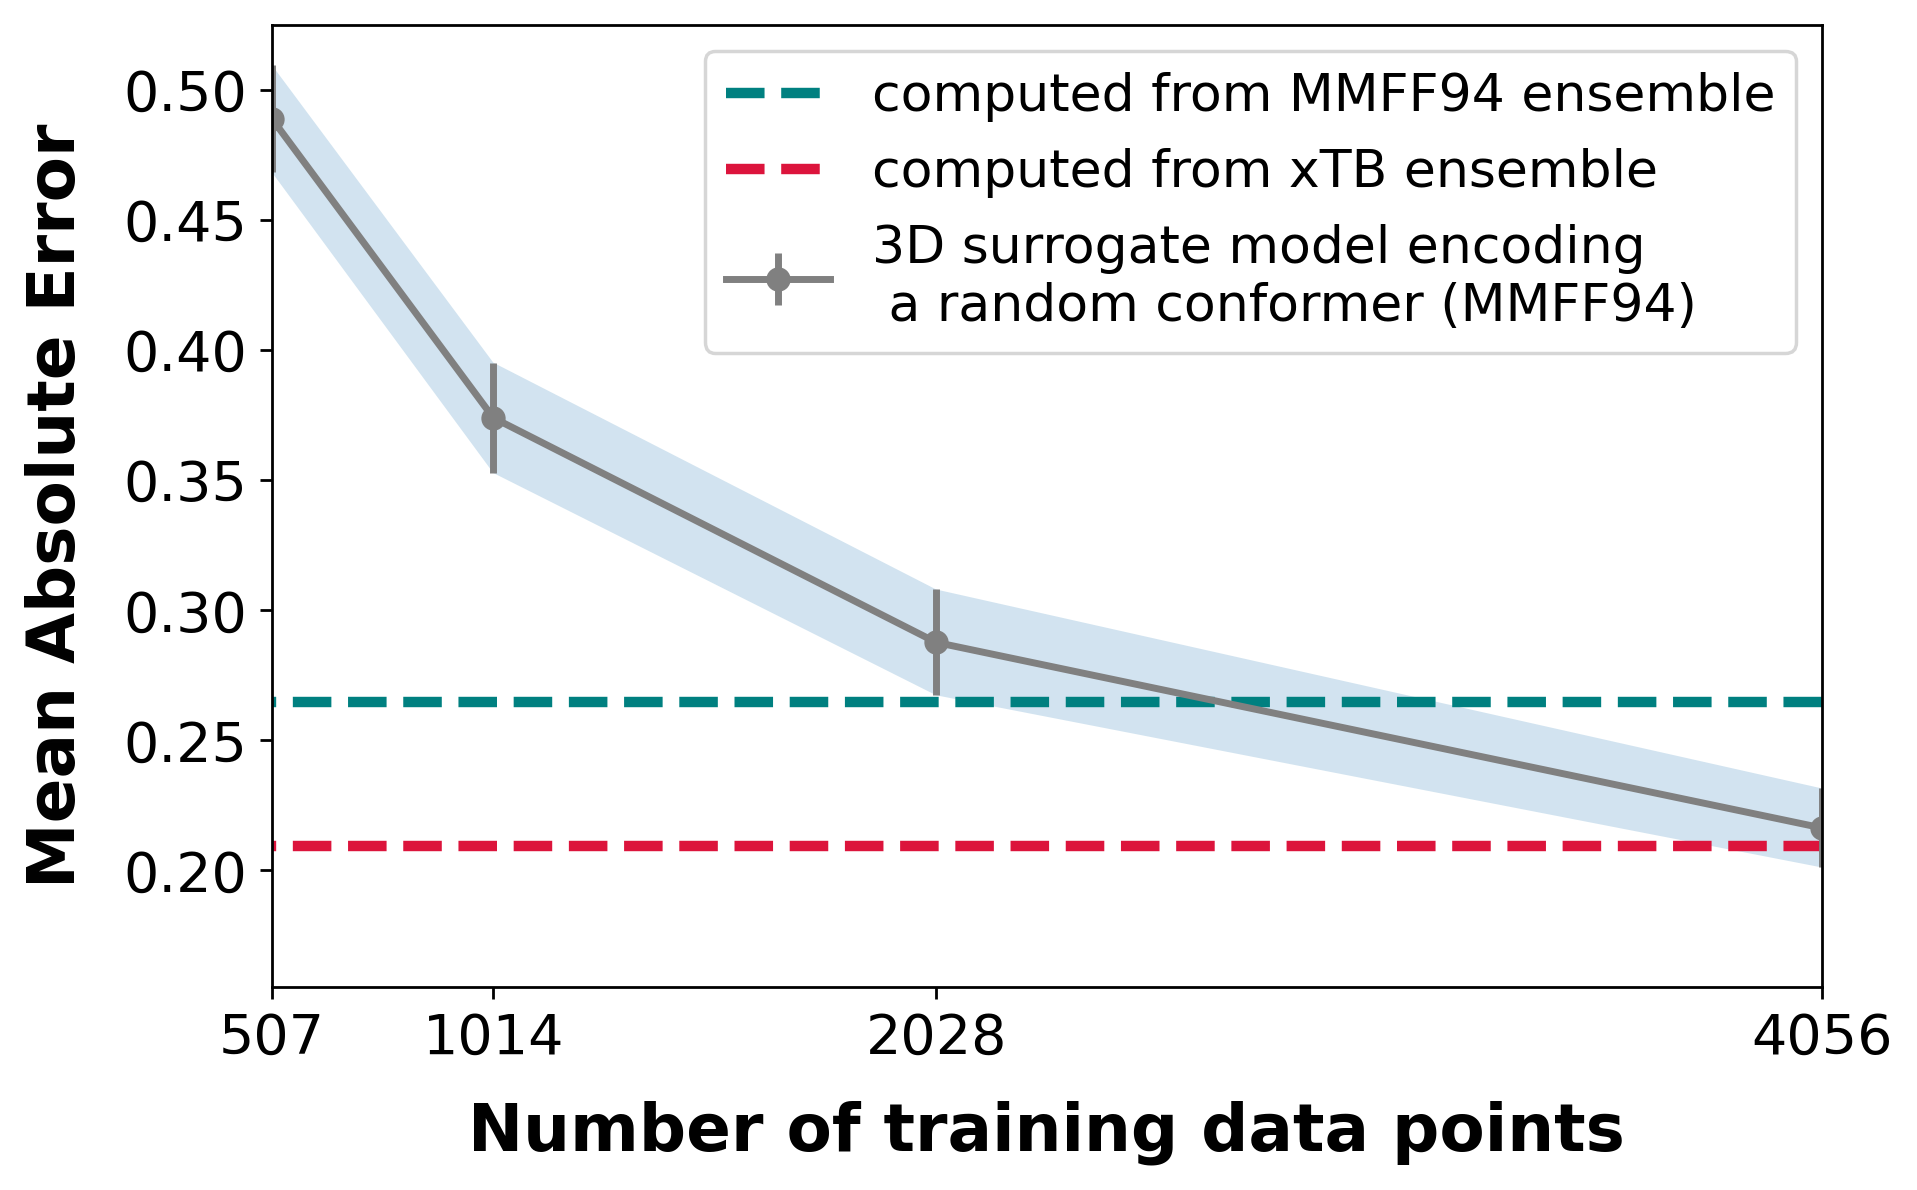

In [25]:
#plt.figure(figsize = (8,6), dpi = 250)
plt.figure(figsize = (8,5), dpi = 250)
x = [1.0, 0.5, 0.25, 0.125]

plt.hlines(y = [np.mean(np.array(computed_rdkit_ensemble_MAE_seeds))], xmin = x[0], xmax = x[-1], color = 'teal', linestyle = '--', label = 'computed from MMFF94 ensemble', linewidth = 3.0)
plt.hlines(y = [np.mean(np.array(computed_xtb_ensemble_MAE_seeds))], xmin = x[0], xmax = x[-1], color = 'crimson', linestyle = '--', label = 'computed from xTB ensemble', linewidth = 3.0)

y = np.mean(np.array(mae_3D_GNN_rdkit_seeds), axis = 0)
yerr=np.std(np.array(mae_3D_GNN_rdkit_seeds), axis = 0)
plt.errorbar(x, y, yerr=yerr, linewidth = 2.0, linestyle = '-', marker = 'o', label = '3D surrogate model encoding\n a random conformer (MMFF94)', color = 'grey');
plt.fill_between(x, y - yerr, y + yerr, alpha=0.2)

#y = np.mean(np.array(mae_3D_GNN_xtb_seeds), axis = 0)
#yerr=np.std(np.array(mae_3D_GNN_xtb_seeds), axis = 0)
#plt.errorbar(x, y, yerr=yerr, linewidth = 2.0, linestyle = '-', marker = 'o', label = 'xTB  surrogate model ', color = 'crimson');
#plt.fill_between(x, y - yerr, y + yerr, alpha=0.2)

plt.ylabel('Mean Absolute Error', fontsize = 19, labelpad = 10, fontweight = 'bold')
plt.xlim(0.125, 1.0)
#plt.xlabel('Fraction of data used to train surrogate models', fontsize = 19, labelpad = 10, fontweight = 'bold')
#plt.xticks(x, ['12.5%', '25%', '50%', '100%'][::-1], fontsize = 16)
plt.xlabel('Number of training data points', fontsize = 19, labelpad = 10, fontweight = 'bold')
plt.xticks(x, ['507', '1014', '2028', '4056'][::-1], fontsize = 16)
plt.yticks(fontsize = 16)
#plt.ylim(0.12, None)
plt.ylim(0.155, None)
plt.xticks(x)
plt.legend(fontsize = 15)
plt.show()